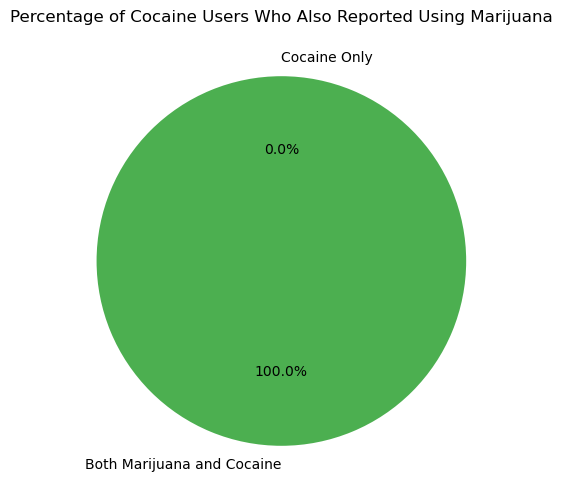

Our sample suggests that everybody who has done Cocaine has also done Weed. This not evidence of a gateway effect but unarguably demonstrates a strong relationship between the two.


In [9]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import recall_score
import seaborn as sns

# read in df
dta_file = '/Users/arikimelman/Downloads/Analytics-Portfolio/Americans-And-Drugs/DS0001/27521-0001-Data.dta'

# load into pandas df
data = pd.read_stata(dta_file)

# Select relevant columns
df = data[['QUESTID','MJEVER','COCEVER','DEPEPISODE','ALCTRY','MJAGE', 'CIGTRY']]


## DATA CLEANING
#-----------------------------------------------------------------------
#Review unique values
unique_values_dict = {
    "COCEVER": df['COCEVER'].unique(),
    "DEPEPISODE": df['DEPEPISODE'].unique(),
    "MJEVER": df['MJEVER'].unique()
}


# Replace 'DON'T KNOW','REFUSED','Blank with NaN across the df
df.replace(["DON'T KNOW", 'REFUSED'], np.nan, inplace=True)
df.replace(["Blank"],np.nan, inplace=True)

# Check for duplicates in IDs 
questid_duplicates = df[df.duplicated(subset=['QUESTID'])]
num_questid_duplicates = questid_duplicates.shape[0]  # Number of duplicate 'QUESTID' values
if num_questid_duplicates > 0:
    df.drop_duplicates(subset=['QUESTID'], inplace=True)

#Convert Depressive Episode to category
df['DEPEPISODE'] = df['DEPEPISODE'].map({'Episode': 1, 'No episode': 0})
df['MJEVER'] = df['MJEVER'].map({'Yes': 1, 'No': 0})
df['COCEVER'] = df['COCEVER'].map({'Yes': 1, 'No': 0})

#Turn any non-numeric value to nan
df['ALCTRY'] = pd.to_numeric(df['ALCTRY'], errors='coerce')
df['MJAGE'] = pd.to_numeric(df['MJAGE'], errors='coerce')
df['CIGTRY'] = pd.to_numeric(df['CIGTRY'], errors='coerce')

#drop all nan
df = df.dropna()

#confirm format of columns are correct
column_types = df.dtypes

#convert ID to string
df['QUESTID'] = df['QUESTID'].astype(str)
#-----------------------------------------------------------------------'''


## QUESTION: Is Marijuana a gateway drug to Cocaine use?
#-----------------------------------------------------------------------'''

df_with_both_drugs = df[(df['COCEVER'] == 1) & (df['MJEVER'] == 1)]
# Percentage of cocaine users who reported also using marijuana
percentage_both_drugs = (len(df_with_both_drugs) / len(df[df['COCEVER'] == 1])) * 100
# Percentage of cocaine users who did not report using marijuana
percentage_cocaine_only = 100 - percentage_both_drugs

# Pie chart: Percentage of Cocaine Users Who Also Reported Using Marijuana
plt.figure(figsize=(8, 6))
labels = ['Both Marijuana and Cocaine', 'Cocaine Only']
sizes = [percentage_both_drugs, percentage_cocaine_only]
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#4CAF50', '#FFC107'])
plt.title('Percentage of Cocaine Users Who Also Reported Using Marijuana')
plt.show()
print("Our sample suggests that everybody who has done Cocaine has also done Weed. This not evidence of a gateway effect but unarguably demonstrates a strong relationship between the two.")
#-----------------------------------------------------------------------


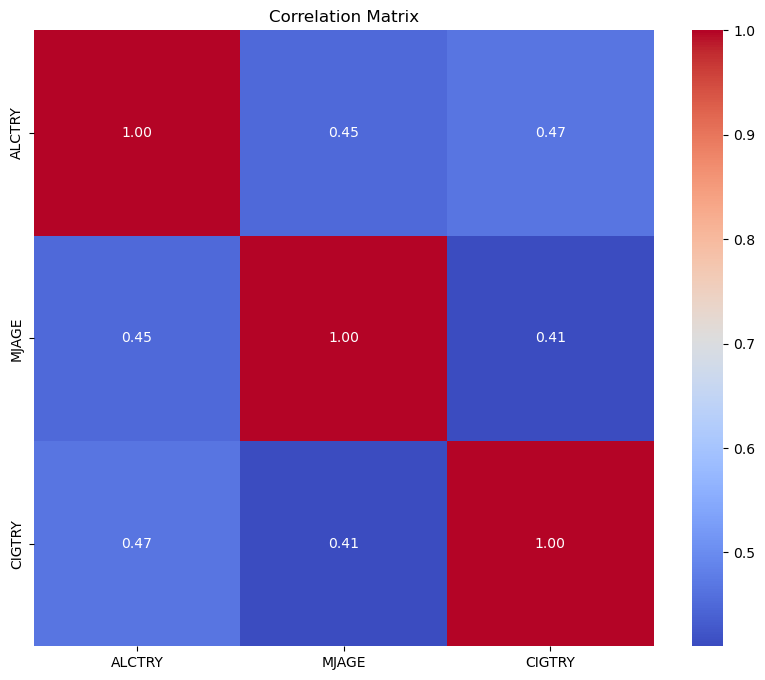


Random Forest (Threshold = 0.5) Accuracy: 0.6603518267929634

Random Forest (Threshold = 0.5) Recall: 0.14977307110438728


In [10]:
## QUESTION: Can we build a machine learning model to predict cocaine use based on the data of the survey? 
#-----------------------------------------------------------------------

## Data preparation

# Normalize numeric variables
scaler = StandardScaler()
numeric_columns = ['ALCTRY', 'MJAGE', 'CIGTRY']
df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

#Create correlation matrix
corr_matrix = df[['MJEVER', 'COCEVER', 'ALCTRY', 'MJAGE', 'CIGTRY', 'DEPEPISODE']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 10})
plt.title('Correlation Matrix')
plt.show()

## Building random forest models


# define features and target
features = df[['MJEVER', 'ALCTRY', 'MJAGE', 'CIGTRY', 'DEPEPISODE']]
target = df['COCEVER']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Build Random Forest and calculate accuracy (Threshold = 0.5)
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("\nRandom Forest (Threshold = 0.5) Accuracy:", accuracy)

# Calculate recall (Threshold = 0.5)
recall_05 = recall_score(y_test, y_pred)
print("\nRandom Forest (Threshold = 0.5) Recall:", recall_05)


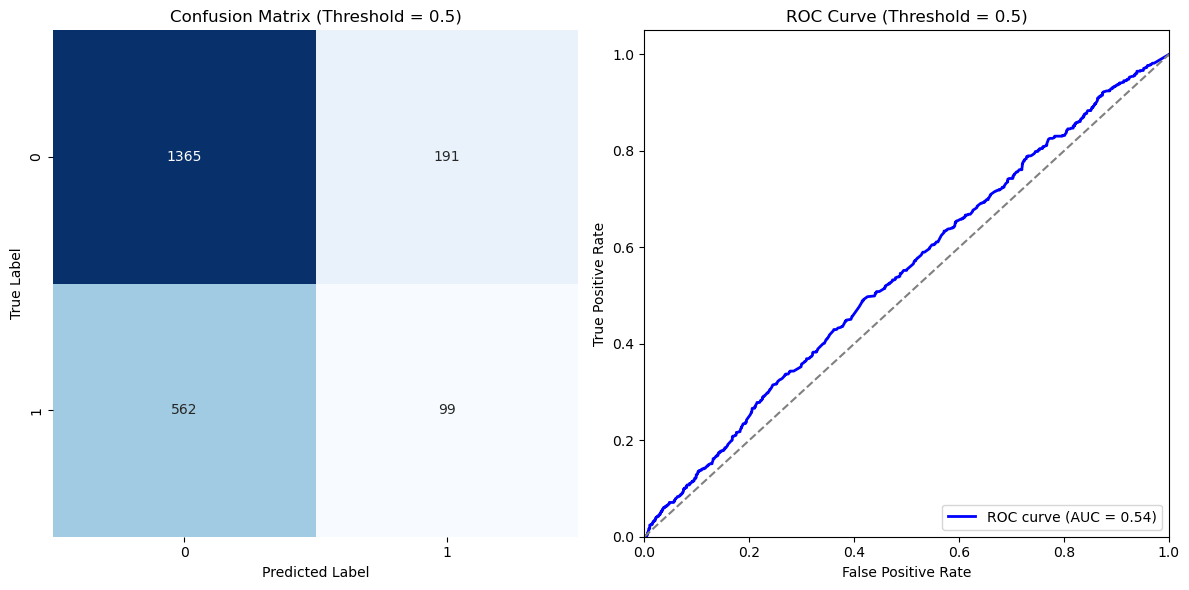



--------------------------------------------------------------------------------------------------------------
Based on our matrix, lets try reducing our threshold because we care less about identifying false positives.
--------------------------------------------------------------------------------------------------------------




In [11]:
# Confusion Matrix (Threshold = 0.5)
conf_matrix_05 = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix_05, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Threshold = 0.5)')

# ROC Curve (Threshold = 0.5)
y_pred_proba_05 = rf_classifier.predict_proba(X_test)[:, 1]
fpr_05, tpr_05, thresholds_05 = roc_curve(y_test, y_pred_proba_05)
auc_score_05 = roc_auc_score(y_test, y_pred_proba_05)
plt.subplot(1, 2, 2)
plt.plot(fpr_05, tpr_05, color='blue', lw=2, label='ROC curve (AUC = {:.2f})'.format(auc_score_05))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Threshold = 0.5)')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

print("\n")
print('-'*110)
print("Based on our matrix, lets try reducing our threshold because we care less about identifying false positives.")
print('-'*110)
print("\n")




Random Forest (Threshold = 0.4) Accuracy: 0.6287776274244474

Random Forest (Threshold = 0.4) Recall: 0.291981845688351




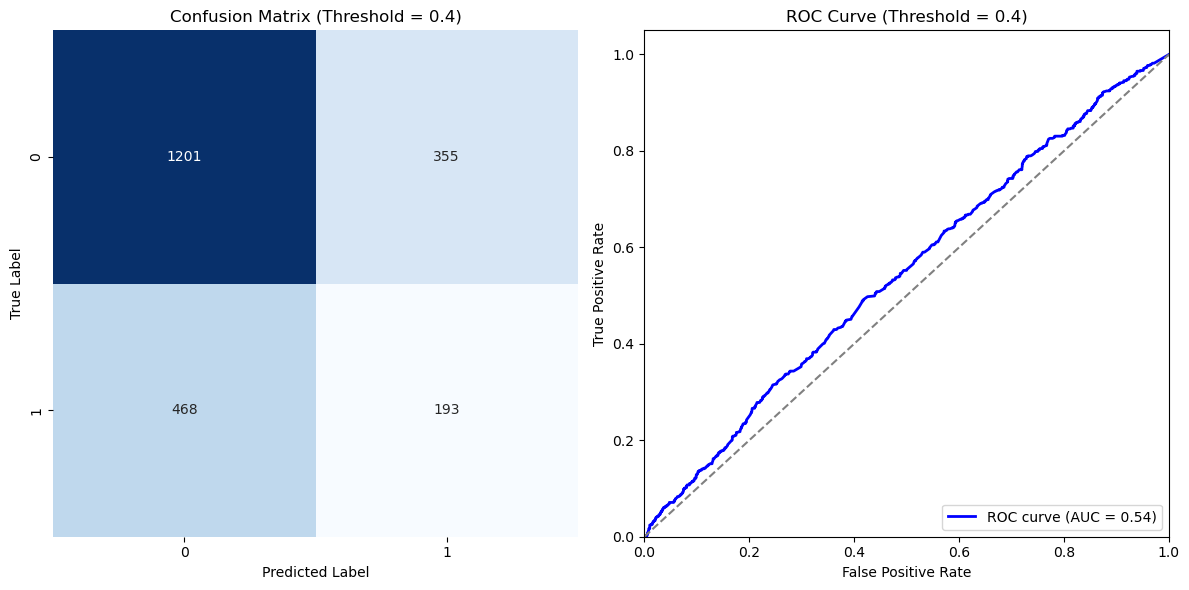

In [12]:
# Random Forest (Threshold = 0.4)
threshold = 0.4
y_pred_04 = (rf_classifier.predict_proba(X_test)[:, 1] >= threshold).astype(int)
accuracy_04 = accuracy_score(y_test, y_pred_04)
print("\nRandom Forest (Threshold = 0.4) Accuracy:", accuracy_04)

# Calculate recall (Threshold = 0.4)
recall_04 = recall_score(y_test, y_pred_04)
print("\nRandom Forest (Threshold = 0.4) Recall:", recall_04)
print("\n")

# Confusion Matrix (Threshold = 0.4)
conf_matrix_04 = confusion_matrix(y_test, y_pred_04)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix_04, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Threshold = 0.4)')

# ROC Curve (Threshold = 0.4)
y_pred_proba_04 = rf_classifier.predict_proba(X_test)[:, 1]
fpr_04, tpr_04, thresholds_04 = roc_curve(y_test, y_pred_proba_04)
auc_score_04 = roc_auc_score(y_test, y_pred_proba_04)
plt.subplot(1, 2, 2)
plt.plot(fpr_04, tpr_04, color='blue', lw=2, label='ROC curve (AUC = {:.2f})'.format(auc_score_04))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Threshold = 0.4)')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()



In [13]:
print("Intepretation: Our accuracy measure is fairly low and our recall is very low (sad face). We were able to slightly improve recall by reducing the threshold, as seen in the updated confusion matrix as well. A realistic conclusion from this analysis is that using information pertaining to when a person firsts begins using substances has some predictive power, but alone this model is insufficient for real world implementation for predicting cocaine usage.")


Intepretation: Our accuracy measure is fairly low and our recall is very low (sad face). We were able to slightly improve recall by reducing the threshold, as seen in the updated confusion matrix as well. A realistic conclusion from this analysis is that using information pertaining to when a person firsts begins using substances has some predictive power, but alone this model is insufficient for real world implementation for predicting cocaine usage.
